<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jul 15 12:09:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 174kB 50.8MB/s 
     |████████████████████████████████| 143kB 38.4MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: fckwmnvj
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/fckwmnvj


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 1vhr954y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
31/31 [==============================] - 31s 242ms/step - loss: 0.1652 - mean_squared_error: 0.1652 - mean_absolute_error: 0.3356 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0941
Epoch 2/200
31/31 [==============================] - 6s 191ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0896 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0698
Epoch 3/200
31/31 [==============================] - 6s 185ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0653 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0765
Epoch 4/200
31/31 [==============================] - 6s 190ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0536 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0686
Epoch 5/200
31/31 [==============================] - 6s 189ms/step - loss: 0.0040 - mean_sq

wandb: Agent Starting Run: adno5h2a with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 9s 416ms/step - loss: 0.1356 - mean_squared_error: 0.1356 - mean_absolute_error: 0.2977 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1817
Epoch 2/50
8/8 [==============================] - 2s 194ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1310 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0754
Epoch 3/50
8/8 [==============================] - 1s 181ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0891 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0704
Epoch 4/50
8/8 [==============================] - 1s 178ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0709 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0660
Epoch 5/50
8/8 [==============================] - 1s 184ms/step - loss: 0.0057 - mean_squared_error: 0.0

wandb: Agent Starting Run: 1gxoszi7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 218ms/step - loss: 0.2045 - mean_squared_error: 0.2045 - mean_absolute_error: 0.3797 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0950
Epoch 2/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0924 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0833
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0855 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0892
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0985 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1051
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0165 - mean_squared_error: 0.

wandb: Agent Starting Run: b8q0veka with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 11s 316ms/step - loss: 2664.4125 - mean_squared_error: 2664.4125 - mean_absolute_error: 5.8508 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1528
Epoch 2/200
16/16 [==============================] - 3s 200ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1963 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1599
Epoch 3/200
16/16 [==============================] - 3s 194ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1219 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0748
Epoch 4/200
16/16 [==============================] - 3s 186ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0663 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0641
Epoch 5/200
16/16 [==============================] - 3s 180ms/step - loss: 0.0047 - m

wandb: Agent Starting Run: s50zykbq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 420ms/step - loss: 0.2190 - mean_squared_error: 0.2190 - mean_absolute_error: 0.4102 - val_loss: 0.1068 - val_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.2779
Epoch 2/50
8/8 [==============================] - 2s 202ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2295 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1014
Epoch 3/50
8/8 [==============================] - 2s 185ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0834 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0933
Epoch 4/50
8/8 [==============================] - 1s 190ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0744 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0783
Epoch 5/50
8/8 [==============================] - 1s 180ms/step - loss: 0.0067 - mean_squared_error: 0.0

wandb: Agent Starting Run: yykb83r3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 59ms/step - loss: 0.0665 - mean_squared_error: 0.0665 - mean_absolute_error: 0.1911 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0714
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0585 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0638
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0503 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0745
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0759
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0047 - mean_squared_error

wandb: Agent Starting Run: 3oebpgb1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 61ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - mean_absolute_error: 0.1874 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0825
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0798 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0666
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0669 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0641
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0784 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0609
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0061 - mean_squared_

wandb: Agent Starting Run: su9kovi1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 8s 227ms/step - loss: 0.1493 - mean_squared_error: 0.1493 - mean_absolute_error: 0.3199 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0986
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0736 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0800
Epoch 3/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0647 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0907
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0798 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0943
Epoch 5/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0052 - mean_squared_error: 0.

wandb: Agent Starting Run: b8gfaps8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 10s 282ms/step - loss: 0.1828 - mean_squared_error: 0.1828 - mean_absolute_error: 0.3256 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0909
Epoch 2/100
16/16 [==============================] - 3s 197ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0826 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0741
Epoch 3/100
16/16 [==============================] - 3s 189ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0714 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0732
Epoch 4/100
16/16 [==============================] - 3s 192ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0726 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0745
Epoch 5/100
16/16 [==============================] - 3s 188ms/step - loss: 0.0250 - mean_sq

wandb: Agent Starting Run: e7xp5sj5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 114ms/step - loss: 0.1019 - mean_squared_error: 0.1019 - mean_absolute_error: 0.2407 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0982
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0669 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0710
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0629 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0699
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0659 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0788
Epoch 5/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0039 - mean_squared

wandb: Processing terminal ouput (stdout)...
wandb: Done.


wandb: Agent Starting Run: p05q2yun with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 110ms/step - loss: 0.1050 - mean_squared_error: 0.1050 - mean_absolute_error: 0.2428 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1086
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0840 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0873
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0631 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0775
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0651 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0837
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_squared

wandb: Agent Starting Run: lmioro4i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 222ms/step - loss: 2.0174 - mean_squared_error: 2.0174 - mean_absolute_error: 0.8274 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0795
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1053 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0958
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0918 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1190
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1154 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1857
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0368 - mean_squared_error: 0.0368 

wandb: Agent Starting Run: zr1slnn4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 10s 416ms/step - loss: 0.1933 - mean_squared_error: 0.1933 - mean_absolute_error: 0.3760 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1062
Epoch 2/50
8/8 [==============================] - 2s 196ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1077 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0923
Epoch 3/50
8/8 [==============================] - 2s 196ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0971 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0726
Epoch 4/50
8/8 [==============================] - 2s 194ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0734 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0732
Epoch 5/50
8/8 [==============================] - 2s 209ms/step - loss: 0.0086 - mean_squared_error: 0.

wandb: Agent Starting Run: 03v3tr0z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 12s 340ms/step - loss: 0.1549 - mean_squared_error: 0.1549 - mean_absolute_error: 0.3173 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0913
Epoch 2/50
16/16 [==============================] - 3s 199ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0815 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0952
Epoch 3/50
16/16 [==============================] - 3s 188ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0923 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0687
Epoch 4/50
16/16 [==============================] - 4s 226ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0641 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0740
Epoch 5/50
16/16 [==============================] - 3s 188ms/step - loss: 0.0064 - mean_squared

wandb: Agent Starting Run: 9a0iow98 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 79ms/step - loss: 0.2428 - mean_squared_error: 0.2428 - mean_absolute_error: 0.2810 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0781
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0722 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0832
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0880 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0707
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0799 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0698
Epoch 5/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0090 - mean_squared_error

wandb: Agent Starting Run: 4djqp5k2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 229ms/step - loss: 0.1394 - mean_squared_error: 0.1394 - mean_absolute_error: 0.3064 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.2069
Epoch 2/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1208 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0841
Epoch 3/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0928 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1351
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0845 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0731
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0085 - mean_squared_error: 0.

wandb: Agent Starting Run: ac3449xg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 8s 62ms/step - loss: 0.2880 - mean_squared_error: 0.2880 - mean_absolute_error: 0.3043 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0780
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1332 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1125
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.1486 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1346
Epoch 4/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1535 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0729
Epoch 5/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0196 - mean_squared_

wandb: Agent Starting Run: vo3lpzp4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 9s 490ms/step - loss: 1453169256519006.7500 - mean_squared_error: 1453169256519006.7500 - mean_absolute_error: 3765901.8020 - val_loss: 0.1593 - val_mean_squared_error: 0.1593 - val_mean_absolute_error: 0.3521
Epoch 2/100
8/8 [==============================] - 2s 199ms/step - loss: 0.1920 - mean_squared_error: 0.1920 - mean_absolute_error: 0.3757 - val_loss: 0.1361 - val_mean_squared_error: 0.1361 - val_mean_absolute_error: 0.3178
Epoch 3/100
8/8 [==============================] - 2s 188ms/step - loss: 3.5783 - mean_squared_error: 3.5783 - mean_absolute_error: 0.4713 - val_loss: 0.1513 - val_mean_squared_error: 0.1513 - val_mean_absolute_error: 0.3408
Epoch 4/100
8/8 [==============================] - 2s 189ms/step - loss: 0.2030 - mean_squared_error: 0.2030 - mean_absolute_error: 0.3924 - val_loss: 0.1508 - val_mean_squared_error: 0.1508 - val_mean_absolute_error: 0.3402
Epoch 5/100
8/8 [==============================] - 2s 191ms/step

wandb: Agent Starting Run: 6wwufgw7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 11s 306ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - mean_absolute_error: 0.3284 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1015
Epoch 2/200
16/16 [==============================] - 3s 205ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0837 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0714
Epoch 3/200
16/16 [==============================] - 3s 197ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0706 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0762
Epoch 4/200
16/16 [==============================] - 3s 186ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0680 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0675
Epoch 5/200
16/16 [==============================] - 3s 205ms/step - loss: 0.0056 - mean_sq

wandb: Agent Starting Run: 2tl8ys2p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 118ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - mean_absolute_error: 0.2979 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1358
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1977 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0726
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0781 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1453
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0795 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0733
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0038 - mean_squared

wandb: Agent Starting Run: y7y9re6h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 14s 252ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1865 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0673
Epoch 2/100
31/31 [==============================] - 6s 192ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0638 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0694
Epoch 3/100
31/31 [==============================] - 6s 201ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0491 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0686
Epoch 4/100
31/31 [==============================] - 6s 205ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0497 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0777
Epoch 5/100
31/31 [==============================] - 6s 200ms/step - loss: 0.0036 - mean_sq

wandb: Agent Starting Run: 8d02e2df with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 8s 244ms/step - loss: 0.1933 - mean_squared_error: 0.1933 - mean_absolute_error: 0.3763 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1596
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1979 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.2150
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1581 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0981
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0980 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0711
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0070 - mean_squared_error: 0.

wandb: Agent Starting Run: ajooajdl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 231ms/step - loss: 0.1769 - mean_squared_error: 0.1769 - mean_absolute_error: 0.3573 - val_loss: 0.0744 - val_mean_squared_error: 0.0744 - val_mean_absolute_error: 0.2628
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1691 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1020
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - mean_absolute_error: 0.1194 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1330
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0969 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0814
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0093 - mean_squared_error: 0.0093 

wandb: Agent Starting Run: amxxj7cq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 15s 262ms/step - loss: 0.1145 - mean_squared_error: 0.1145 - mean_absolute_error: 0.2570 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0864
Epoch 2/100
31/31 [==============================] - 6s 191ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0772 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0664
Epoch 3/100
31/31 [==============================] - 6s 200ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0740 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0720
Epoch 4/100
31/31 [==============================] - 6s 207ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0653 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0675
Epoch 5/100
31/31 [==============================] - 6s 204ms/step - loss: 0.0070 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'dropout': 0.1,
    'learning_rate': 0.001,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 7s 13ms/step - loss: 0.0579
Epoch 2/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0054
Epoch 3/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0060
Epoch 4/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0032
Epoch 5/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0043
Epoch 6/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 7/200
20/20 [==============================] - 0s 16ms/step - loss: 0.0031
Epoch 8/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0040
Epoch 9/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 10/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0025
Epoch 11/200
20/20 [==============================] - 0s 15ms/step - loss: 0.0033
Epoch 12/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0023
Epoch 13/200
20/20 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

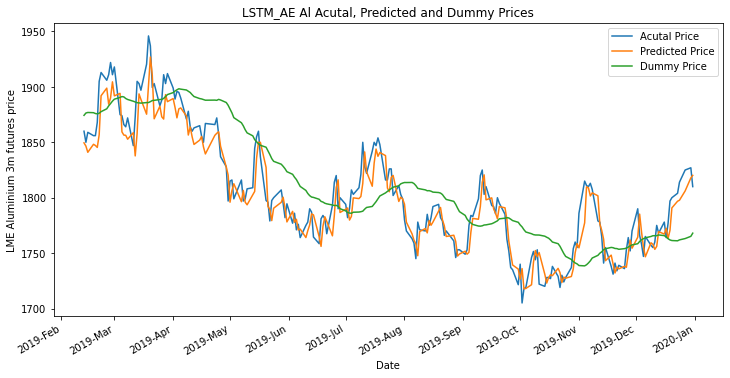

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

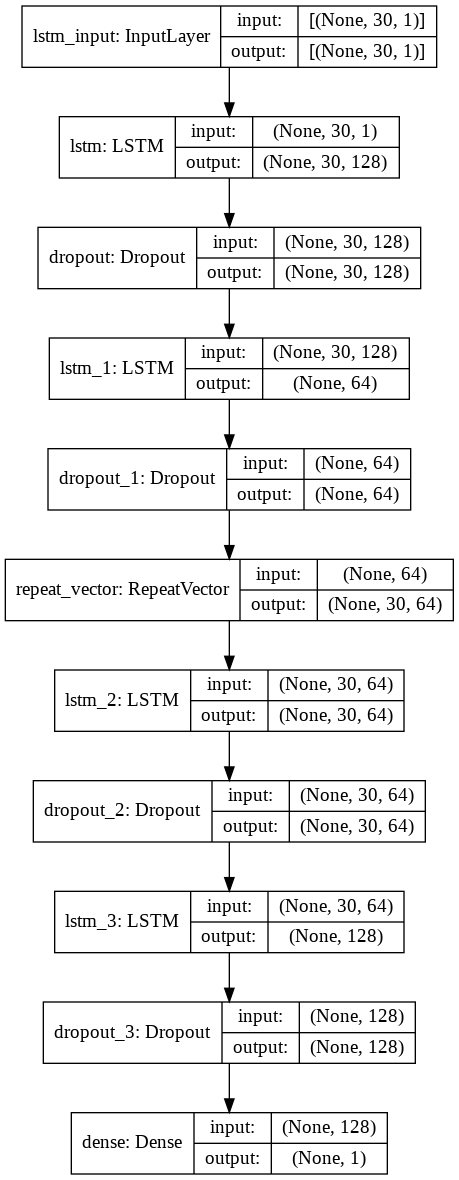

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004457189603491352
RMSE:  0.06676218692861516
MAE:  0.05275795933147482
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Al/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Al/assets
